In [63]:
# !pip install "deeplake<4"
# !pip install transformers
# !pip install nltk
# !pip install torchvision

In [64]:
import torch
import torch.nn as nn

import deeplake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms
from transformers import BertTokenizer, BertModel
import nltk
import random

from torch.utils.data import Dataset
from PIL import Image

## Preprocess Data

In [65]:
ds = deeplake.load('hub://activeloop/flickr30k')

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k



-

hub://activeloop/flickr30k loaded successfully.



In [66]:
images = ds.image
captions = ds.caption_0 ## NextSteps: currently only training on caption0, could include other set of captions

### Tokenizing

In [67]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [90]:
## ALL Hyperparameters 
caption_max_length = 20 
vocab_size = len(tokenizer)

In [68]:
def process_image(image):
  """
  Image transformation functions
  Resizes images to 224x224, converts to tensor, and normalizes
  The normalization parameters are mean, SD of of r, g, b pixel values
  """
  image_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  image = image.numpy()
  image = Image.fromarray(image)
  image = image_transform(image)
  return image


def process_caption(caption_text):
  """
  Tokenizes captions
  Returns tensor of tokenized captions, with a max length of 20,
  padding until this length, and truncating if the caption is longer
  The individual entries in the tensor are integers
  """

  tokenized = tokenizer(caption_text,
                        max_length=caption_max_length,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt')

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']
  return input_ids

def untokenize(tokenized_text):
    """
    Untokenizes a tensor
    Takes a tensor of integers, and according to tokenizer, returns
    original words
    """
    return tokenizer.decode(tokenized_text, skip_special_tokens=True)


#### Tests

tests for tokenizer

In [69]:
strings = ["hello world", "my dog went to the store", "the earth revolves around the sun",
           "I travelled to new york city and ate mexican and japanese food"]

def test_tokenizer(strings):
    """
    Function to test tokenizer, by tokenizing and untokenizing a string
    """
    for string in strings:
        # print ("input string: " + string)
        check = untokenize(process_caption(string)[0])
        # print ("output string: " + check)
        assert check.lower() == string.lower()
    print("All tests passed!")
test_tokenizer(strings)

All tests passed!


In [70]:
tokenizer.tokenize("Hello I am Wendy")
tokenizer.encode("Hello I am Wendy", add_special_tokens = True)

[101, 7592, 1045, 2572, 12815, 102]

### tests for data processing

In [71]:
def test_process_image():
  test_img = ds.image[0]
  transformed_img = process_image(test_img)
  assert transformed_img.size(1) == 224 and transformed_img.size(2) == 224, "Image resizing failed."
  assert transformed_img.size(0) == 3, "Image channel mismatch."
  print("All tests passed!")

test_process_image()


All tests passed!


In [72]:
def test_process_caption():
  caption = "A dog playing in the park."
  input_ids = process_caption(caption)
  assert input_ids.size(1) == 20, "Tokenized length incorrect."

  decoded_caption = untokenize(input_ids[0])
  assert decoded_caption.lower() == caption.lower(), "Caption untokenization incorrect."
  print("All tests passed!")
test_process_caption()

All tests passed!


### Dataset/Dataloader Creation

In [73]:
class Flickr30kDataset(Dataset):
    def __init__(self, images, captions, image_transform=None, caption_transform = None):
      """
      Initializes dataset
      """
      self.images = images
      self.captions = captions
      self.image_transform = image_transform
      self.caption_transform = caption_transform

    def __len__(self):
      """
      Returns length of the dataset
      """
      return len(self.captions)

    def __getitem__(self, idx):
      """
      Returns a single item (image, and caption processed according to
      caption_transform) from the dataset
      """
      image = self.images[idx]
      image = self.image_transform(image)

      caption = self.captions[idx].numpy()[0]
      caption_embedding = self.caption_transform(caption)
      return image, caption_embedding


In [74]:
from torch.utils.data import DataLoader, random_split

flickr_dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)

# 80% train, 10% val, 10% Test 
train_size = int(0.8 * len(flickr_dataset))
val_size = int(0.1 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_dataset, eval_dataset, test_dataset = random_split(flickr_dataset, [train_size, val_size, test_size])

batch_size = 32 # TODO
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [75]:
## SMALLER DATASET FOR SAMPLE 
from torch.utils.data import Subset
import random

# TODO:
train_n = 200
eval_n = 20
batch = 1

train_indices = random.sample(range(len(flickr_dataset)), train_n)
train_subset = Subset(flickr_dataset, train_indices)
mini_train_dataloader = DataLoader(train_subset, batch_size=batch, shuffle=False)

eval_indices = random.sample(range(len(flickr_dataset)), eval_n)
eval_subset = Subset(flickr_dataset, eval_indices)
mini_eval_dataloader = DataLoader(eval_subset, batch_size=batch, shuffle=False)

#### Tests

tests for dataset

In [76]:
def test_flickr30k_dataset():
    dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)
    assert len(dataset) == len(captions), "Dataset length mismatch."

    image, caption_embedding = dataset[0]
    assert image.size(0) == 3 and image.size(1) == 224 and image.size(2) == 224, "Image shape incorrect."
    assert caption_embedding.size(1) == 20, "Caption max length incorrect."
    print("All tests passed!")

test_flickr30k_dataset()

All tests passed!


## CNN

In [77]:
class CNN(nn.Module):
  def __init__(self):
    """
    Initializes convolutional neural network
    """
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)

    self.relu = nn.ReLU()
    self.fc = nn.Linear(in_features=288, out_features=1024)
    self.fc2 = nn.Linear(1024, 256)
    self.flatten = nn.Flatten()

    self.maxPool = nn.MaxPool2d((2, 2), stride=2)

    self.batchNorm1 = nn.BatchNorm2d(4)
    self.batchNorm2 = nn.BatchNorm2d(16)
    self.batchNorm3 = nn.BatchNorm2d(32)

  def forward(self, x):
    """
    Forward pass of convolutional neural network
    """
    # for each layer, run convolutional layer, batch normalization layer,
    # then maxPool layer
    layer1 = self.maxPool(self.relu(self.batchNorm1(self.conv1(x))))
    layer2 = self.maxPool(self.relu(self.batchNorm2(self.conv2(layer1))))
    layer3 = self.maxPool(self.relu(self.batchNorm3(self.conv3(layer2))))
    x1 = self.flatten(layer3)
    # print(x1.shape) # 1, 288
    hidden = self.relu(self.fc(x1)) #1, 1024
    x = self.fc2(hidden) # 1, 4
    # print(x.shape )
    return x


#### Tests

Tests for CNN

In [78]:
def test_cnn_forward_pass():
    cnn_model = CNN().to("cpu")
    test_img = torch.randn(1, 3, 224, 224).to("cpu")
    features = cnn_model(test_img)
    assert features.size(1) == 256, "CNN dimension incorrect."

test_cnn_forward_pass()

## RNN

In [79]:
print("vocab size", tokenizer.vocab_size)
print("embed dim", bert_model.config.hidden_size)


vocab size 30522
embed dim 768


In [80]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size = 30522, embed_dim = 768, feature_dim = 256, hidden_dim= 512, max_length= 20):
      """
      Initializes RNN
      vocab_size = vocab size of bert tokenizer
      embed_dim = bert_model config hidden size
      feature_dim = from CNN output
      hidden_dim = hidden dimension of RNN
      """

      super(DecoderRNN, self).__init__()
      # embedding layer
      self.embedding = nn.Embedding(vocab_size, embed_dim)
      # long-short term memory nodes
      self.lstm = nn.LSTM(embed_dim + feature_dim, hidden_dim, batch_first=True)
      self.fc = nn.Linear(hidden_dim, vocab_size)
      self.max_length = max_length
      self.hidden_dim = hidden_dim

    def init_hidden(self, batch_size):
      """
      initialize hidden layer of model
      """
      return (torch.zeros(1, batch_size, self.hidden_dim).to(device), # h
              torch.zeros(1, batch_size, self.hidden_dim).to(device)) # c

    def forward(self, features, captions, hidden = None):
      """
      Runs one step of RNN
      """
      # Note: Initial caption is the <START> token
      embeddings = self.embedding(captions)  # (batch_size, max_length, embed_dim)
      features = torch.unsqueeze(features, 1) # (batch, 1, feature )
      inputs = torch.cat((features, embeddings), dim=2)  # (batch_size, max_length, embed_dim + feature_dim)

      lstm_out, hidden = self.lstm(inputs, hidden)  # (batch_size, max_length, hidden_dim)
      outputs = self.fc(lstm_out)  # (batch_size, max_length, vocab_size)
      return outputs, hidden


## TRAIN




In [81]:
def train_model(cnn, rnn, data_loader, ratio = 0.5, device="cpu"):
  cnn.train()
  rnn.train()
  for epoch in range(num_epochs):
    total_loss = 0.0
    for images, captions in data_loader:
      images = images.to(device)
      captions = captions.to(device).long()

      batch_size = len(images) # for each item images set how many are there
      hidden = rnn.init_hidden(batch_size)

      optimizer_cnn.zero_grad()
      optimizer_rnn.zero_grad()

      features = cnn(images)
      captions = captions.squeeze(1)

      # Get the <Start> token
      decoder_input = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

      outputs = []

      # Teacher-forcing alg
      if random.random() < ratio:
        use_force = True
      else:
        use_force = True

      # Note RNN predicts one step ahead - cuz of the <start> token
      seq_length = captions.size(1)
      for t in range(1, seq_length):

          output, hidden = rnn(features, decoder_input, hidden)
          outputs.append(output)

          if use_force:
              decoder_input = captions[:, t].unsqueeze(1) # use true caption
          else:
              decoder_input = output.argmax(dim=2)

      outputs = torch.cat(outputs, dim=1)  # (batch , seq length - 1, vocab_size) 2, 19, vocabsize
      outputs = outputs.reshape(-1, outputs.size(2))  # batch * (seqlength - 1), vocab_size

      caption_original = captions[:, 1:]  #( batch , (seqlength - 1) )
      caption_original = caption_original.contiguous().view(-1) #batch * (seqlength - 1)

      loss = criterion(outputs, caption_original)

      loss.backward()
      optimizer_cnn.step()
      optimizer_rnn.step()
      total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save model after each epoch
    # cnn_save_path = f'{home}cnn_epoch_{epoch + 1}.pth'
    # rnn_save_path = f'{home}rnn_epoch_{epoch + 1}.pth'
    # optimizer_cnn_save_path = f'{home}optimizer_cnn_epoch_{epoch + 1}.pth'
    # optimizer_rnn_save_path = f'{home}optimizer_rnn_epoch_{epoch + 1}.pth'

    # torch.save(cnn.state_dict(), cnn_save_path)
    # torch.save(rnn.state_dict(), rnn_save_path)
    # torch.save(optimizer_cnn.state_dict(), optimizer_cnn_save_path)
    # torch.save(optimizer_rnn.state_dict(), optimizer_rnn_save_path)

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model = CNN().to(device)
rnn_model = DecoderRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

num_epochs = 10


In [83]:
train_model(cnn_model, rnn_model, mini_train_dataloader, device=device)

KeyboardInterrupt: 

## Eval

In [29]:
def eval_model(cnn, rnn, data_loader, device):
  cnn.eval()
  rnn.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, captions in data_loader:
      images = images.to(device)
      captions = captions.to(device).long()
      captions = captions.squeeze(1)

      # set batch and hidden
      batch_size = len(images)
      hidden = rnn.init_hidden(batch_size)

      features = cnn(images)
      decoder_input = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device) # start
      seq_length = captions.size(1)

      outputs = []

      for t in range(1, seq_length):
          output, hidden = rnn(features, decoder_input, hidden)

          decoder_input = output.argmax(dim=2)
          outputs.append(output)

      outputs = torch.cat(outputs, dim=1) #stack
      outputs = outputs.reshape(-1, outputs.size(2))

      caption_original = captions[:, 1:]
      caption_original = caption_original.contiguous().view(-1) #batch * (seqlength - 1)

      loss = criterion(outputs, caption_original)
      total_loss += loss.item()

  avg_loss = total_loss / len(data_loader)

  print(f"Validation Loss: {avg_loss:.4f}")
  return avg_loss


In [30]:
eval_model(cnn_model, rnn_model, mini_eval_dataloader, device=device)

Validation Loss: 12.5152


12.51524085998535

## Predict

In [31]:
def predict(cnn, rnn, image, device='cpu'):
  cnn.eval()
  rnn.eval()
  image = image.to(device)

  with torch.no_grad():
      features = cnn(image)


  batch_size = 1
  max_length = 20

  start_token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

  hidden = rnn.init_hidden(batch_size)
  predictions = []
  input = start_token

  for _ in range(max_length):
      with torch.no_grad():
          output, hidden = rnn(features, input, hidden)
          # print(output[0])
          predicted_token = output.argmax(dim=2)
          # print(predicted_token)
          predictions.append(predicted_token.item())

          input = predicted_token

          # if predict a </e> end token, Exit
          if predicted_token.item() == tokenizer.sep_token_id:
              break

  predictions = untokenize(predictions)
  return predictions

Sample run

caption: ['Men dressed in red and men dressed in white are playing a game of soccer .']
Predicted Caption: a man in a blue shirt playing the harp.


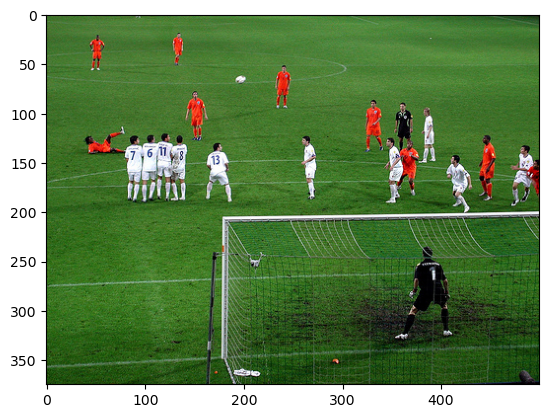

In [32]:
## SAMPLE RUN
index = 9
test_image = ds.image[index]
plt.imshow(test_image.numpy())
print("caption:" , ds.caption_0[index].numpy())

## Process this test_image
processed_test_image = process_image(test_image).unsqueeze(0)
predicted_caption = predict(cnn_model, rnn_model, processed_test_image, device=device)
print("Predicted Caption:", predicted_caption)